In [1]:
import datajoint as dj
import numpy as np
import tifffile as tf
import matplotlib.pyplot as plt
import retinotopic_mapping
import retinotopic_mapping.tools.FileTools as ft
import retinotopic_mapping.RetinotopicMapping as rm

In [2]:
# Set up your connection to the database server
dj.config['database.host'] = '139.91.171.210:3306'
dj.config['database.user'] = 'eflab'
dj.config['database.password'] = 'cajal123'

dj.conn()

Connecting eflab@139.91.171.210:3306


DataJoint connection (connected) eflab@139.91.171.210:3306

In [3]:
# list the names of database schemas available to you
dj.list_schemas()

In [4]:
# we start by creating a schema object to connect to the chosen database schema
schema = dj.schema('pipeline_map')
# schema = dj.schema('tutorial', locals())
# If the schema already exists, dj.schema is initialized as usual and you may plot the schema diagram.
# But instead of seeing class names, you will see the raw table names as they appear in the database.

In [5]:
# let's plot its diagram -- gives error!!
#dj.Diagram(schema)

In [6]:
# to spawn classes into the local namespace for any tables missing their classes
schema.spawn_missing_classes()

In [7]:
opt_image_bar = OptImageBar()
opt_image_bar

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,axis the direction of bar movement,amp amplitude of the fft phase spectrum,ang angle of the fft phase spectrum,vessels,selected,pxpitch pixel pitch of the map (microns per pixel)
9254,1,4,horizontal,=BLOB=,=BLOB=,=BLOB=,1,7.421875
9254,1,5,vertical,=BLOB=,=BLOB=,=BLOB=,1,7.421875
9329,1,4,horizontal,=BLOB=,=BLOB=,=BLOB=,1,7.421875
9329,1,5,vertical,=BLOB=,=BLOB=,=BLOB=,0,7.421875
9329,1,6,horizontal,=BLOB=,=BLOB=,=BLOB=,0,7.421875
9329,2,5,horizontal,=BLOB=,=BLOB=,=BLOB=,0,7.421875
9329,2,6,vertical,=BLOB=,=BLOB=,=BLOB=,0,7.421875
9508,1,5,horizontal,=BLOB=,=BLOB=,=BLOB=,1,7.421875
9508,1,6,vertical,=BLOB=,=BLOB=,=BLOB=,0,7.421875
9579,1,6,horizontal,=BLOB=,=BLOB=,=BLOB=,1,7.421875


In [8]:
ret_map_scan = RetMapScan()
ret_map_scan

animal_id id number,ret_idx retinotopy map index for each animal,session session index for the mouse,scan_idx number of TIFF stack file,axis the direction of bar movement
9254,1,1,4,horizontal
9254,1,1,5,vertical
9329,1,1,5,vertical
9329,1,1,6,horizontal
9508,1,1,5,horizontal
9508,1,1,6,vertical
9579,1,1,6,horizontal
9579,1,1,7,vertical
9580,1,2,5,horizontal
9580,1,2,6,vertical


In [9]:
# query data for animal 9254 only
query = opt_image_bar & 'animal_id = 9254'
query

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,axis the direction of bar movement,amp amplitude of the fft phase spectrum,ang angle of the fft phase spectrum,vessels,selected,pxpitch pixel pitch of the map (microns per pixel)
9254,1,4,horizontal,=BLOB=,=BLOB=,=BLOB=,1,7.421875
9254,1,5,vertical,=BLOB=,=BLOB=,=BLOB=,1,7.421875


In [10]:
# split horizontal (azi) and vertical (alt)
azi_query = query & 'axis = "horizontal"'
azi_query

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,axis the direction of bar movement,amp amplitude of the fft phase spectrum,ang angle of the fft phase spectrum,vessels,selected,pxpitch pixel pitch of the map (microns per pixel)
9254,1,4,horizontal,=BLOB=,=BLOB=,=BLOB=,1,7.421875


In [11]:
# split horizontal (azi) and vertical (alt)
alt_query = query & 'axis = "vertical"'
alt_query

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,axis the direction of bar movement,amp amplitude of the fft phase spectrum,ang angle of the fft phase spectrum,vessels,selected,pxpitch pixel pitch of the map (microns per pixel)
9254,1,5,vertical,=BLOB=,=BLOB=,=BLOB=,1,7.421875


In [12]:
azi_amp, azi_ang, azi_vessels = azi_query.fetch1('amp', 'ang', 'vessels')
alt_amp, alt_ang, alt_vessels = alt_query.fetch1('amp', 'ang', 'vessels')


In [13]:
# azi_vessels.shape

Text(0.5, 1.0, 'alt_vessels')

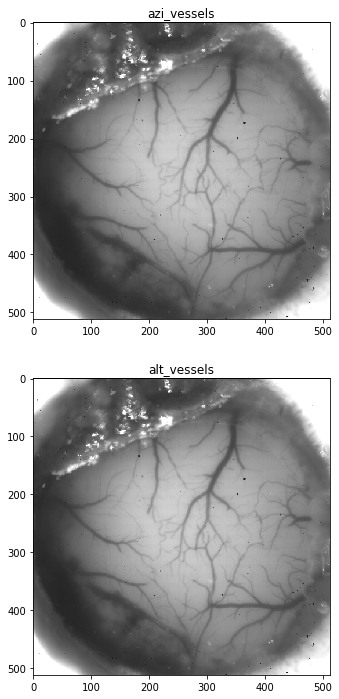

In [14]:
f = plt.figure(figsize=(15, 12))

plt.subplot(211)
plt.imshow(azi_vessels, cmap='gray', interpolation='nearest')
plt.title('azi_vessels')

plt.subplot(212)
plt.imshow(alt_vessels, cmap='gray', interpolation='nearest')
plt.title('alt_vessels')

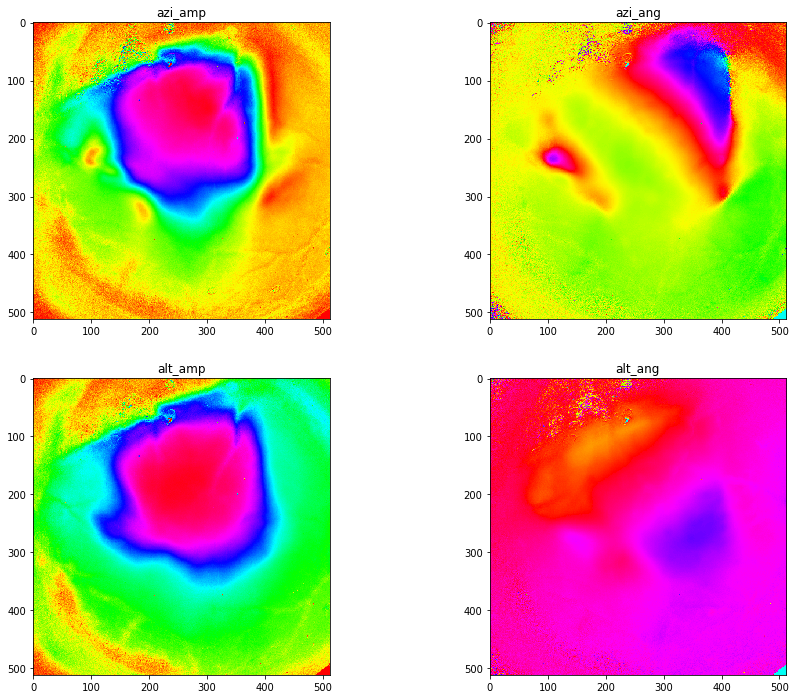

In [15]:
f = plt.figure(figsize=(15, 12))

plt.subplot(221)
plt.imshow(azi_amp, cmap='hsv', interpolation='nearest')
#plt.plot(azi_amp)
plt.title('azi_amp')

plt.subplot(222)
plt.imshow(azi_ang, cmap='hsv', interpolation='nearest')
#plt.plot(azi_ang)
plt.title('azi_ang')

plt.subplot(223)
plt.imshow(alt_amp, cmap='hsv', interpolation='nearest')
#plt.plot(alt_amp)
plt.title('alt_amp')

plt.subplot(224)
plt.imshow(alt_ang, cmap='hsv', interpolation='nearest')
#plt.plot(alt_ang)
plt.title('alt_ang')

plt.show()

In [16]:
params = {
          'phaseMapFilterSigma': 0.5,
          'signMapFilterSigma': 8.,
          'signMapThr': 0.4,
          'eccMapFilterSigma': 15.0,
          'splitLocalMinCutStep': 5.,
          'closeIter': 3,
          'openIter': 3,
          'dilationIter': 15,
          'borderWidth': 1,
          'smallPatchThr': 100,
          'visualSpacePixelSize': 0.5,
          'visualSpaceCloseIter': 15,
          'splitOverlapThr': 1.1,
          'mergeOverlapThr': 0.1
          }

In [17]:
trial = rm.RetinotopicMappingTrial(altPosMap=alt_ang,
                                   aziPosMap=azi_ang,
                                   altPowerMap=alt_amp,
                                   aziPowerMap=azi_amp,
                                   vasculatureMap=azi_vessels,
                                   mouseID='9254',
                                   dateRecorded='160612',
                                   comments='This is an example.',
                                   params=params)

In [18]:
print (trial)

A retinotopic mapping trial: 160612_M9254


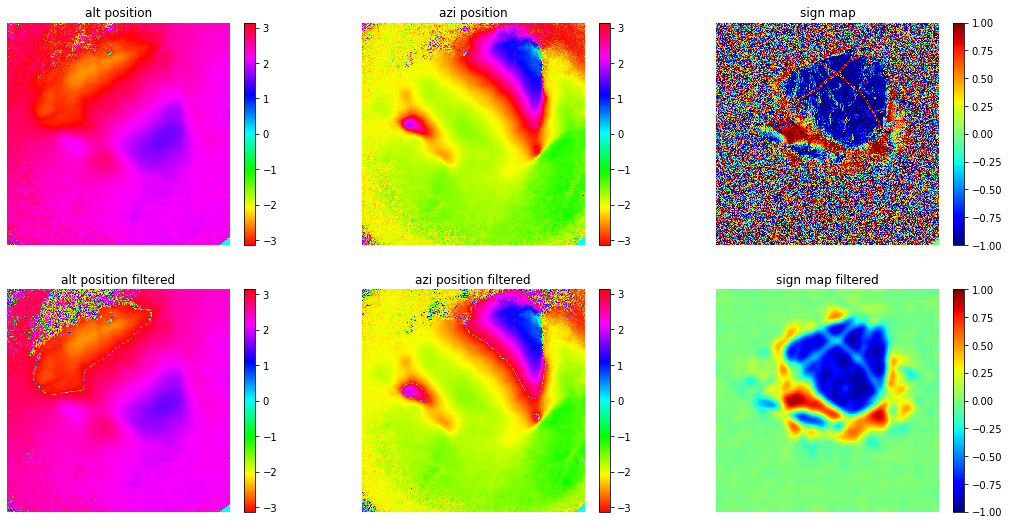

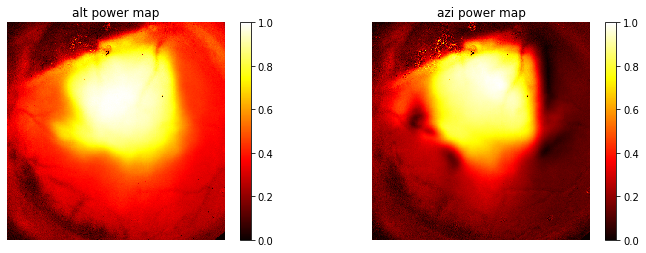

In [19]:
_ = trial._getSignMap(isPlot=True, isFixedRange=False)
plt.show()

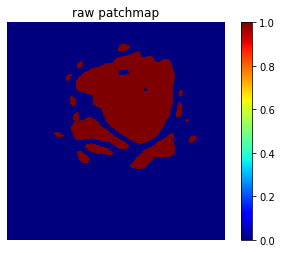

In [20]:
_ = trial._getRawPatchMap(isPlot=True)
plt.show()

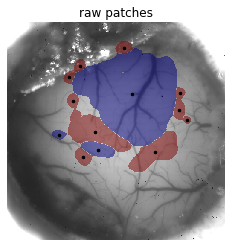

In [21]:
_ = trial._getRawPatches(isPlot=True)
plt.show()

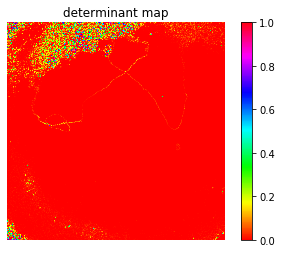

In [22]:
_ = trial._getDeterminantMap(isPlot=True)
plt.show()

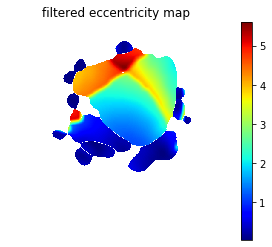

In [23]:
_ = trial._getEccentricityMap(isPlot=True)
plt.show()

patch01AU=40.5 AS=71.45216 ratio=1.7642509554639274
Only one local minumum was found!!!
patch02AU=21.0 AS=9.011017 ratio=0.4290960402715774


/home/mariad/retinotopic_mapping/RetinotopicMapping.py:397: RuntimeWarning: invalid value encountered in less_equal
  marker[eccMap2 <= (currThr)] = 1


patch03AU=3.0 AS=1.2170327 ratio=0.40567755699157715
patch04AU=1.0 AS=0.19438677 ratio=0.19438676536083221
patch05AU=1.0 AS=0.2545462 ratio=0.254546195268631
patch06AU=3.5 AS=2.0622785 ratio=0.5892224311828613
patch07AU=1.5 AS=0.28748584 ratio=0.19165722529093424
patch08AU=0.75 AS=0.048653312 ratio=0.0648710827032725
patch09AU=0.5 AS=0.06762681 ratio=0.13525362312793732
patch10AU=0.5 AS=0.04800765 ratio=0.09601529687643051
patch11AU=1.5 AS=0.4081177 ratio=0.2720784743626912
patch12AU=1.0 AS=0.36035958 ratio=0.3603595793247223
patch13AU=0.5 AS=0.09814507 ratio=0.19629013538360596


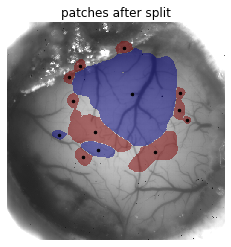

In [24]:
_ = trial._splitPatches(isPlot=True)
plt.show()

merge iteration: 1


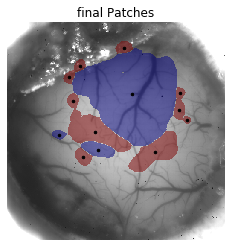

In [25]:
_ = trial._mergePatches(isPlot=True)
plt.show()

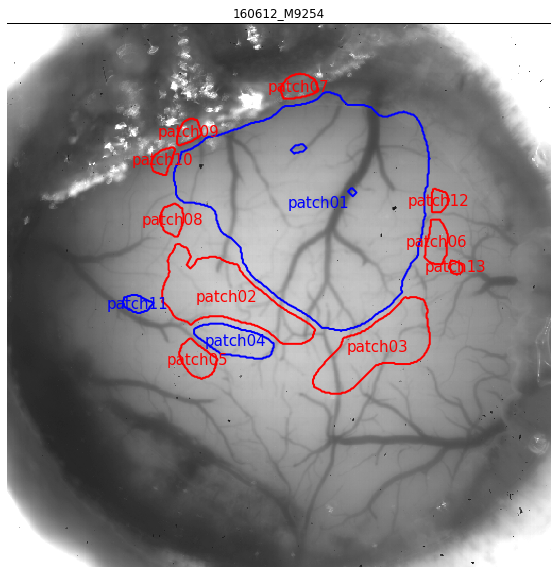

In [26]:
_ = trial.plotFinalPatchBorders2()
plt.show()

In [27]:
# default values
paramsd = {
          'phaseMapFilterSigma': 1.0,
          'signMapFilterSigma': 9.,
          'signMapThr': 0.35,
          'eccMapFilterSigma': 10.0,
          'splitLocalMinCutStep': 5.,
          'closeIter': 3,
          'openIter': 3,
          'dilationIter': 15,
          'borderWidth': 1,
          'smallPatchThr': 100,
          'visualSpacePixelSize': 0.5,
          'visualSpaceCloseIter': 15,
          'splitOverlapThr': 1.1,
          'mergeOverlapThr': 0.1
          }

In [28]:
triald = rm.RetinotopicMappingTrial(altPosMap=alt_ang,
                                   aziPosMap=azi_ang,
                                   altPowerMap=alt_amp,
                                   aziPowerMap=azi_amp,
                                   vasculatureMap=azi_vessels,
                                   mouseID='9254',
                                   dateRecorded='160612',
                                   comments='This is an example.',
                                   params=paramsd)

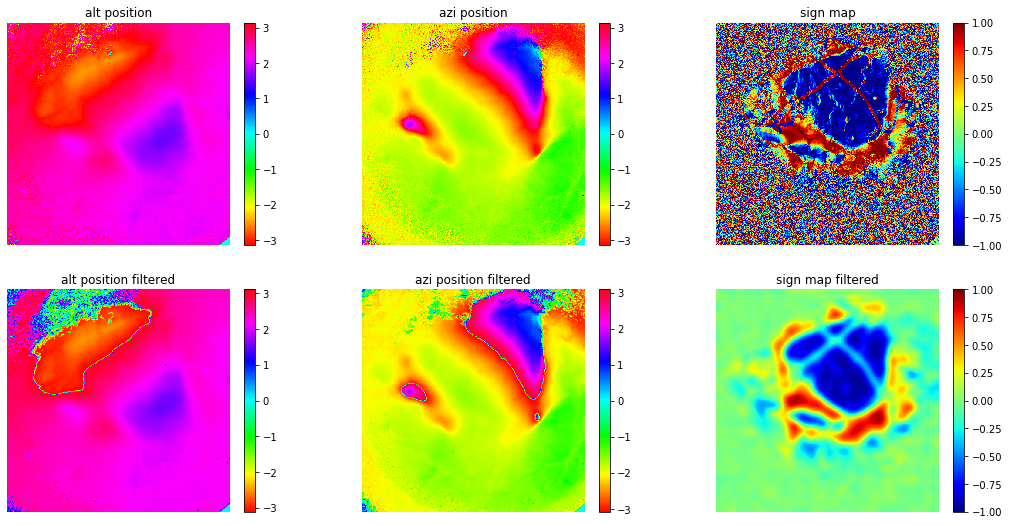

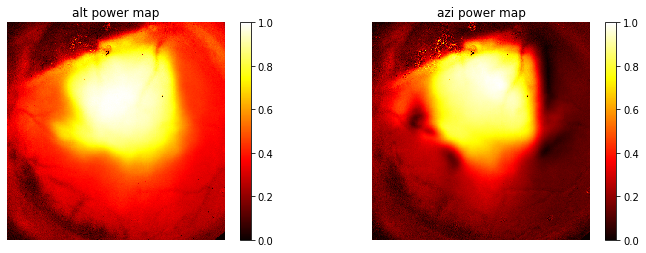

In [29]:
_ = triald._getSignMap(isPlot=True, isFixedRange=False)
plt.show()

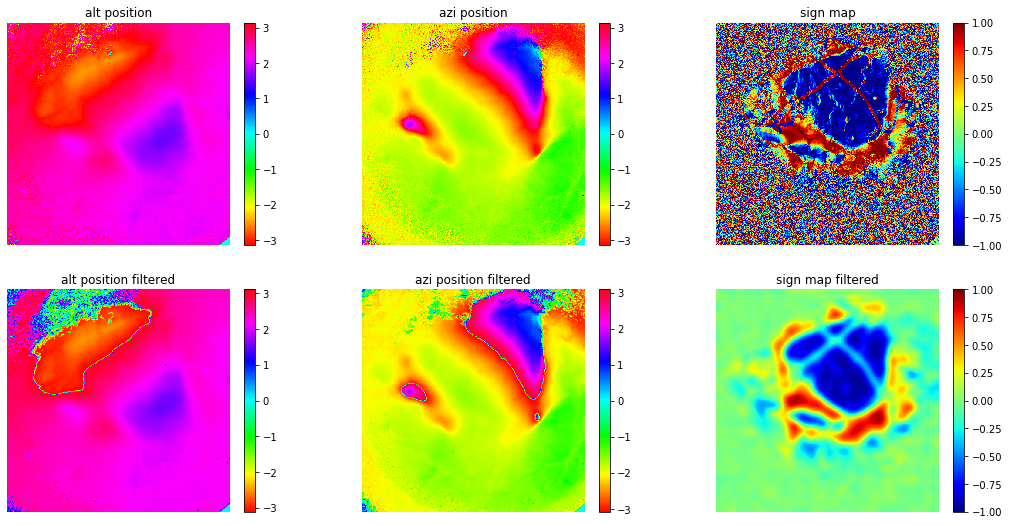

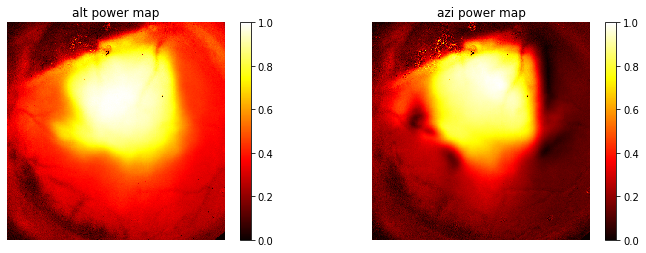

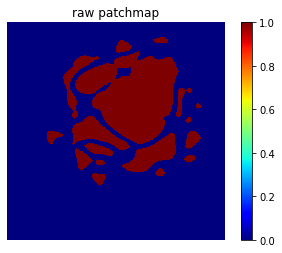

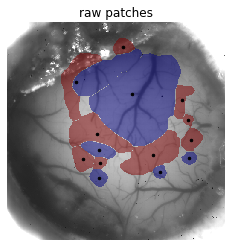

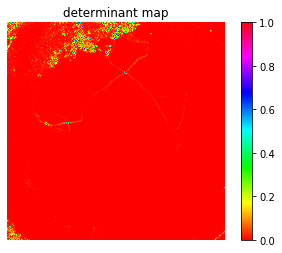

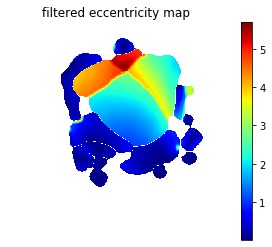

patch01AU=47.5 AS=63.089478 ratio=1.328199527138158
Only one local minumum was found!!!
patch02AU=3.75 AS=1.5820519 ratio=0.4218804995218913


/home/mariad/retinotopic_mapping/RetinotopicMapping.py:397: RuntimeWarning: invalid value encountered in less_equal
  marker[eccMap2 <= (currThr)] = 1


patch03AU=14.5 AS=6.2589736 ratio=0.43165335161932583
patch04AU=3.0 AS=1.2294056 ratio=0.4098018805185954
patch05AU=3.75 AS=3.1543882 ratio=0.8411701838175456
patch06AU=1.0 AS=0.28139353 ratio=0.28139352798461914
patch07AU=1.0 AS=0.1818015 ratio=0.18180149793624878
patch08AU=1.5 AS=0.38013744 ratio=0.2534249623616536
patch09AU=4.0 AS=0.9624176 ratio=0.24060440063476562
patch10AU=1.0 AS=0.07613625 ratio=0.07613624632358551
patch11AU=0.5 AS=0.04928968 ratio=0.09857936203479767
patch12AU=1.0 AS=0.03236837 ratio=0.03236836940050125
patch13AU=0.5 AS=0.050648782 ratio=0.10129756480455399
patch14AU=0.75 AS=0.1329771 ratio=0.17730279763539633


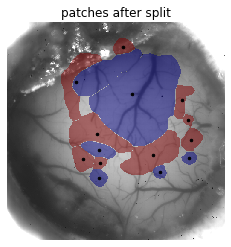

merge iteration: 1


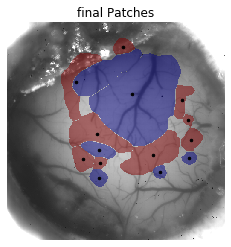

In [30]:
triald.processTrial(isPlot=True)

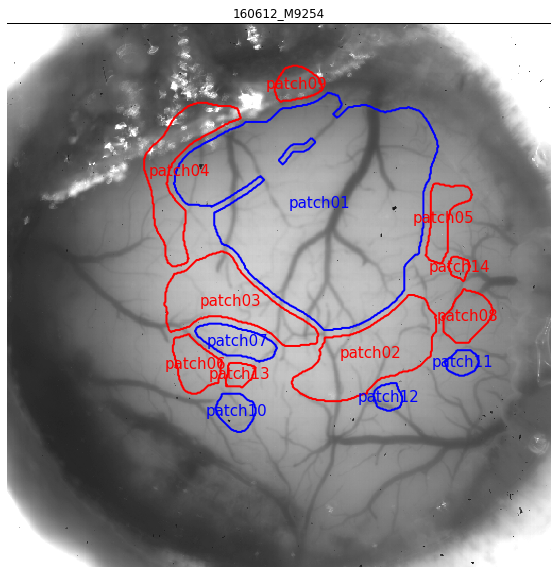

In [31]:
_ = triald.plotFinalPatchBorders2()
plt.show()